# Importing the Libraries

In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D, ReLU, Concatenate
from keras import regularizers, optimizers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import layers
from keras.metrics import categorical_crossentropy
from tensorflow.keras import Model, Input
from tensorflow.keras import utils
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import augmentations

# Loading and Preprocessing the Data


In [2]:
%cp /content/drive/MyDrive/Dataset/ -r /content/

In [37]:
train = tf.keras.utils.image_dataset_from_directory(
    '/content/Dataset/Train',
    labels='inferred' ,
    label_mode = 'categorical',
    color_mode="rgb",
    image_size=(64, 64),
    shuffle=True,
    batch_size=128,
    seed= 10,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

val = tf.keras.utils.image_dataset_from_directory(
    '/content/Dataset/Val',
    labels='inferred' ,
    label_mode = 'categorical',
    color_mode="rgb",
    image_size=(64, 64),
    shuffle=False,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

test = tf.keras.utils.image_dataset_from_directory(
    '/content/Dataset/Test',
    labels='inferred' ,
    label_mode = 'categorical',
    color_mode="rgb",
    image_size=(64, 64),
    shuffle=False,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 5908 files belonging to 4 classes.
Found 855 files belonging to 4 classes.
Found 825 files belonging to 4 classes.


In [38]:
aug = tf.keras.Sequential([
  layers.RandomRotation(factor=(-0.2, 0.3)),
  augmentations.RandomColorJitter(),
  augmentations.RandomGaussianNoise(),
])

train2 = train.map(lambda x, y: (aug(x), y))

In [39]:
y_test = np.concatenate([y for x, y in val], axis=0).astype('uint8')
x_test = np.concatenate([x for x, y in val], axis=0).astype('uint8')

In [40]:
train = train.concatenate(train2)

# Implementing the Network and Training it

In [42]:
input = Input(shape=(64,64,3))
a = layers.Rescaling(1./255)(input)
a = Conv2D(filters=3, kernel_size=1, padding='same')(a)
x = Conv2D(filters=32, kernel_size=3, kernel_regularizer=regularizers.l2(1e-3), padding='same')(a)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(filters=32, kernel_size=3, kernel_regularizer=regularizers.l2(1e-3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.3)(x)
x = Conv2D(filters=128, kernel_size=3, kernel_regularizer=regularizers.l2(1e-3), padding='same')(a)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(filters=128, kernel_size=3, kernel_regularizer=regularizers.l2(1e-3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.3)(x)
x = GlobalAveragePooling2D()(x)
outputs = Dense(4, activation='softmax')(x)

In [43]:
model = tf.keras.Model(inputs=input, outputs=outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 3)         12        
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 128)       3584      
                                                                 
 batch_normalization_10 (Bat  (None, 64, 64, 128)      512       
 chNormalization)                                                
                                                                 
 re_lu_10 (ReLU)             (None, 64, 64, 128)       0         
                                                           

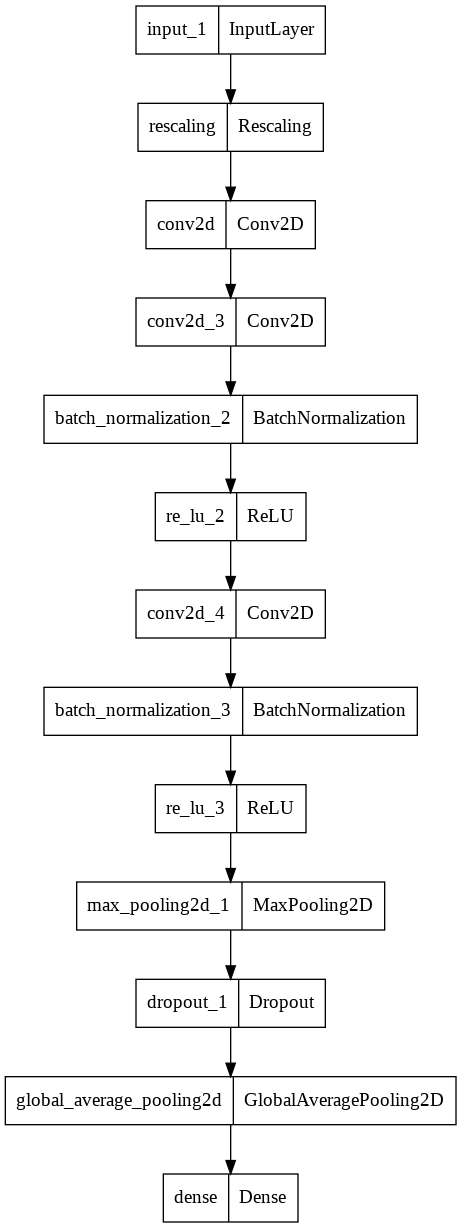

In [12]:
tf.keras.utils.plot_model(model)

In [22]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-3 * 10**(-epoch/30))

checkpointer = keras.callbacks.ModelCheckpoint(filepath='model.hdf5', save_best_only=True, monitor='val_loss')
callbacks = [checkpointer ,
            lr_schedule]

In [44]:
model.compile(optimizer=Adam(), loss=['categorical_crossentropy'], metrics=['accuracy'])

In [45]:
history = model.fit(train, validation_data=val, epochs=10, verbose=1, callbacks=[callbacks])

Epoch 1/10
94/94 [==============================] - 14s 136ms/step - loss: 1.0419 - accuracy: 0.6741 - val_loss: 1.7217 - val_accuracy: 0.2526 - lr: 0.0010
Epoch 2/10
94/94 [==============================] - 13s 135ms/step - loss: 0.6531 - accuracy: 0.8257 - val_loss: 2.6721 - val_accuracy: 0.2526 - lr: 9.2612e-04
Epoch 3/10
94/94 [==============================] - 13s 135ms/step - loss: 0.4812 - accuracy: 0.8953 - val_loss: 3.8832 - val_accuracy: 0.2526 - lr: 8.5770e-04
Epoch 4/10
94/94 [==============================] - 14s 138ms/step - loss: 0.3705 - accuracy: 0.9370 - val_loss: 4.0637 - val_accuracy: 0.2526 - lr: 7.9433e-04
Epoch 5/10
94/94 [==============================] - 13s 136ms/step - loss: 0.3005 - accuracy: 0.9593 - val_loss: 2.2409 - val_accuracy: 0.3310 - lr: 7.3564e-04
Epoch 6/10
94/94 [==============================] - 13s 136ms/step - loss: 0.2372 - accuracy: 0.9734 - val_loss: 2.9392 - val_accuracy: 0.3368 - lr: 6.8129e-04
Epoch 7/10
94/94 [==========================

We can see some improvements so we train more

In [46]:
history2 = model.fit(train, validation_data=val, epochs=20, verbose=1, callbacks=[callbacks])

Epoch 1/20
94/94 [==============================] - 14s 139ms/step - loss: 0.1490 - accuracy: 0.9857 - val_loss: 25.7854 - val_accuracy: 0.2491 - lr: 0.0010
Epoch 2/20
94/94 [==============================] - 13s 137ms/step - loss: 0.1414 - accuracy: 0.9871 - val_loss: 8.5278 - val_accuracy: 0.3918 - lr: 9.2612e-04
Epoch 3/20
94/94 [==============================] - 13s 136ms/step - loss: 0.1255 - accuracy: 0.9884 - val_loss: 12.9296 - val_accuracy: 0.2550 - lr: 8.5770e-04
Epoch 4/20
94/94 [==============================] - 13s 137ms/step - loss: 0.1362 - accuracy: 0.9854 - val_loss: 5.8788 - val_accuracy: 0.3322 - lr: 7.9433e-04
Epoch 5/20
94/94 [==============================] - 14s 139ms/step - loss: 0.1221 - accuracy: 0.9887 - val_loss: 3.8781 - val_accuracy: 0.5333 - lr: 7.3564e-04
Epoch 6/20
94/94 [==============================] - 13s 137ms/step - loss: 0.1013 - accuracy: 0.9925 - val_loss: 5.9959 - val_accuracy: 0.3240 - lr: 6.8129e-04
Epoch 7/20
94/94 [========================

We need to lower the learning rate

In [51]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(-epoch/10))

checkpointer = keras.callbacks.ModelCheckpoint(filepath='model.hdf5', save_best_only=True, monitor='val_loss')
callbacks = [checkpointer ,
            lr_schedule]
history3 = model.fit(train, validation_data=val, epochs=20, verbose=1, callbacks=[callbacks])

Epoch 1/20
94/94 [==============================] - 14s 138ms/step - loss: 0.0663 - accuracy: 0.9988 - val_loss: 0.4011 - val_accuracy: 0.8339 - lr: 1.0000e-05
Epoch 2/20
94/94 [==============================] - 13s 136ms/step - loss: 0.0649 - accuracy: 0.9983 - val_loss: 0.1431 - val_accuracy: 0.9591 - lr: 7.9433e-06
Epoch 3/20
94/94 [==============================] - 13s 136ms/step - loss: 0.0641 - accuracy: 0.9986 - val_loss: 0.1762 - val_accuracy: 0.9661 - lr: 6.3096e-06
Epoch 4/20
94/94 [==============================] - 13s 136ms/step - loss: 0.0631 - accuracy: 0.9986 - val_loss: 0.1980 - val_accuracy: 0.9661 - lr: 5.0119e-06
Epoch 5/20
94/94 [==============================] - 13s 137ms/step - loss: 0.0624 - accuracy: 0.9982 - val_loss: 0.2085 - val_accuracy: 0.9661 - lr: 3.9811e-06
Epoch 6/20
94/94 [==============================] - 13s 137ms/step - loss: 0.0633 - accuracy: 0.9984 - val_loss: 0.2014 - val_accuracy: 0.9661 - lr: 3.1623e-06
Epoch 7/20
94/94 [======================

# Evaluation

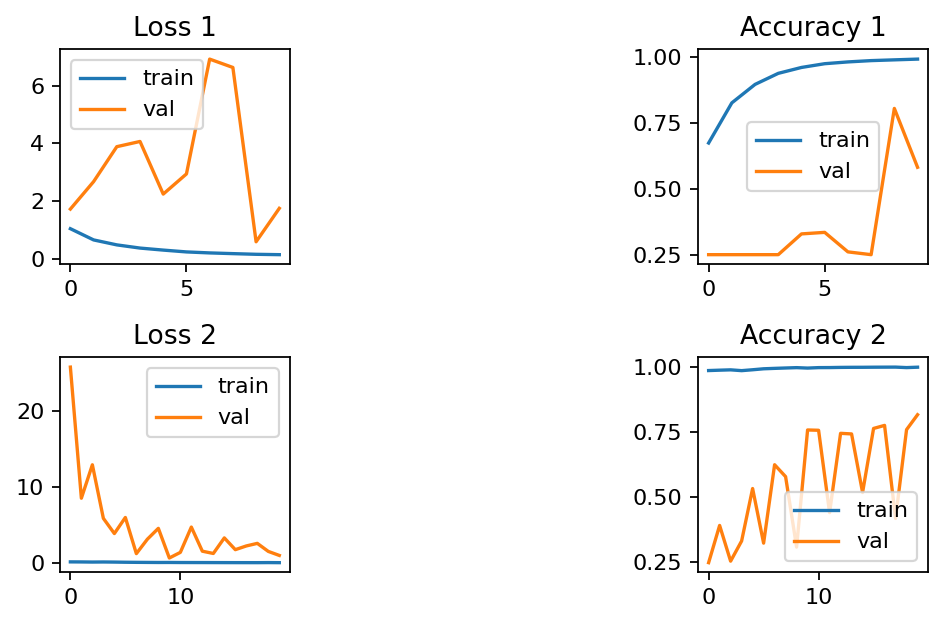

In [61]:
plt.figure( dpi=160)

plt.subplot(231)
plt.title('Loss 1')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

plt.subplot(233)
plt.title('Accuracy 1')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()

plt.subplot(234)
plt.title('Loss 2')
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='val')
plt.legend()

plt.subplot(236)
plt.title('Accuracy 2')
plt.plot(history2.history['accuracy'], label='train')
plt.plot(history2.history['val_accuracy'], label='val')
plt.legend()
plt.tight_layout()
plt.show()

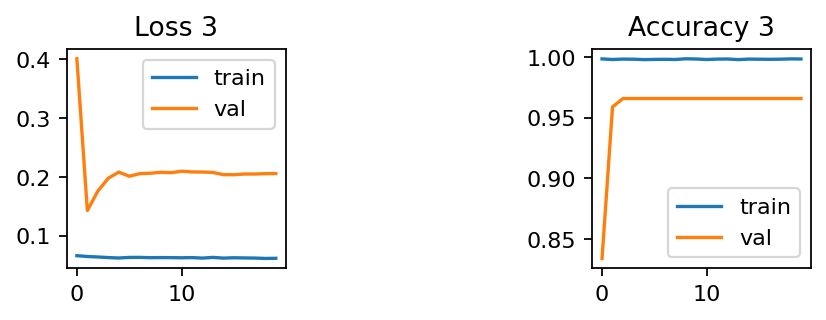

In [60]:
plt.figure( dpi=160)

plt.subplot(231)
plt.title('Loss 3')
plt.plot(history3.history['loss'], label='train')
plt.plot(history3.history['val_loss'], label='val')
plt.legend()

plt.subplot(233)
plt.title('Accuracy 3')
plt.plot(history3.history['accuracy'], label='train')
plt.plot(history3.history['val_accuracy'], label='val')
plt.legend()
plt.show()

In [57]:
y_hat = model.predict(x_test)

27/27 [==============================] - 0s 11ms/step


In [58]:
y_hat[y_hat>=0.5] = 1
y_hat[y_hat<0.5] = 0


For Test Set
F1 score:  0.947008547008547
Accuracy:  0.92046783625731
Precision:  0.9233333333333333
Recall:  0.9719298245614035
Confusion Matrix: 



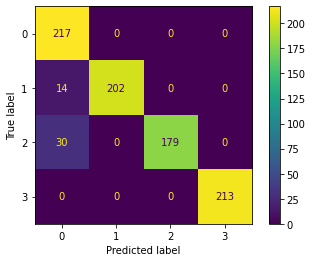

In [59]:
print('\nFor Test Set')
f1 = f1_score(y_test, y_hat, average='micro')
print('F1 score: ' , f1)

accuracy = accuracy_score(y_test, y_hat)
print('Accuracy: ' , accuracy)

precision = precision_score(y_test, y_hat, average='micro')
print('Precision: ' , precision)

recall = recall_score(y_test, y_hat, average='micro')
print('Recall: ' , recall)

matrix = ConfusionMatrixDisplay(confusion_matrix(y_test.argmax(axis=1), y_hat.argmax(axis=1)))
print('Confusion Matrix: \n')
matrix.plot()
plt.show()